# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = ""

---

**Exercise sheet 3**

Code from the lectures:

In [2]:
import numpy as np
import matplotlib.pylab as plt

rng = np.random.default_rng()
%matplotlib inline

def sample_acceptance_rejection(sample_z,accept_probability):
    while True:
        x = sample_z()
        if rng.random() < accept_probability(x):
            return x     
        
def estimate_expectation(sampler,n):
    '''Compute beste estimate of mean and 1-sigma error with n samples.'''
    samples = [sampler() for _ in range(n)]
    return np.mean(samples), np.std(samples)/np.sqrt(n-1)

def estimate_expectation_one_pass(sampler,n):
    sample_mean = sample_square_dev = 0.0
    for k in range(1,n+1):
        delta = sampler() - sample_mean
        sample_mean += delta / k
        sample_square_dev += (k-1)*delta*delta/k  
    return sample_mean, np.sqrt(sample_square_dev / (n*(n-1)))

## Acceptance-rejection sampling

**(35 points)**

The goal of this exercise is to develop a fast sampling algorithm of the discrete random variable $X$ with probability mass function $$p_X(k) = \frac{6}{\pi^2} k^{-2}, \qquad k=1,2,\ldots$$

__(a)__ Let $Z$ be the discrete random variable with $p_Z(k) = \frac{1}{k} - \frac{1}{k+1}$ for $k=1,2,\ldots$. Write a function to compute the inverse CDF $F_Z^{-1}(u)$, such that you can use the inversion method to sample $Z$ efficiently. **(15 pts)**

In [3]:
def f_inverse_Z(u):
    '''Compute the inverse CDF of Z, i.e. F_Z^{-1}(u) for 0 <= u <= 1.'''
    assert 0 <= u and u <= 1
    
    # we need to round to return a natural number (excluding zero, yes).
    return np.ceil(u/(1 - u)).astype(int)

def random_Z():
    return int(f_inverse_Z(rng.random())) # make sure to return an integer

In [4]:
assert f_inverse_Z(0.2)==1
assert f_inverse_Z(0.51)==2
assert f_inverse_Z(0.76)==4
assert f_inverse_Z(0.991)==111

__(b)__ Implement a sampler for $X$ using acceptance-rejection based on the sampler of $Z$. For this you need to first determine a $c$ such that $p_X(k) \leq c\,p_Z(k)$ for all $k=1,2,\ldots$, and then consider an acceptance probability $p_X(k) / (c p_Z(k))$. Verify the validity of your sampler numerically (e.g. for $k=1,\ldots,10$). **(20 pts)**

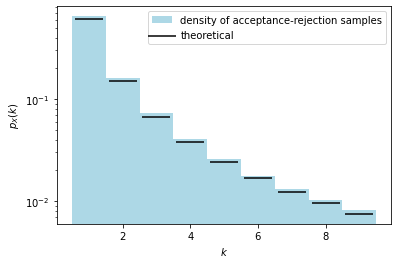

In [5]:
def accept_probability_X(k):
    '''Return the appropriate acceptance probability on the event Z=k.'''
    
    # The resulting c is found by doing algebraic things, and seeing that
    # 6/pi^2*(1 + 1/k) <= c should hold for all allowed k. For k = 1, c is
    # the largest, so: tada.
    c = 12*np.pi**(-2)
    
    # But we do not need this variable, we only need the acceptance probability.
    return .5*(1 + 1/k)
    
def random_X():
    return sample_acceptance_rejection(random_Z,accept_probability_X)

# Verify numerically
samples = [random_X() for _ in range(1000000)]
k = np.array(range(1,11))

# The theoretical densities to compare the densities from the
# acceptance-rejection densities to:
p_X = lambda k: 6/(np.pi*k)**2

plt.figure()
plt.hist(samples, k - .5, density=True, color="lightblue", label="density of acceptance-rejection samples")
plt.scatter(k[:-1], [p_X(i) for i in k[:-1]], s=800, marker="_", color="black", label="theoretical")
plt.yscale("log")
plt.ylabel("$p_X(k)$")
plt.xlabel("$k$")
plt.legend()
plt.show()
# TODO: The histogram overshoots the theoretical value every time.

In [6]:
from nose.tools import assert_almost_equal
assert min([random_X() for _ in range(10000)]) >= 1
assert_almost_equal([random_X() for _ in range(10000)].count(1),6079,delta=400)
assert_almost_equal([random_X() for _ in range(10000)].count(3),675,delta=75)

## Monte Carlo integration & Importance sampling

**(30 Points)**

Consider the integral 

$$
I = \int_0^1 \sin(\pi x(1-x))\mathrm{d}x = \mathbb{E}[X], \quad X=g(U), \quad g(U)=\sin(\pi U(1-U)),
$$ 

where $U$ is a uniform random variable in $(0,1)$.

__(a)__ Use Monte Carlo integration based on sampling $U$ to estimate $I$ with $1\sigma$ error at most $0.001$. How many samples do you need? (It is not necessary to automate this: trial and error is sufficient.) **(10 pts)**

In [7]:
def sample_X():
    x = rng.random()
    return np.sin(np.pi*x*(1 - x))

n = 43402
sample_mean, sample_stdev = estimate_expectation(sample_X, n)
print("""
After trial and error, I found that {} trials were sufficient to arrive at an 1-sigma error of around 0.001,
with mean {:.6f} and standard deviation sigma {:.6f}. Wolfram Alpha tells me it should be approximately I =
{}, so I am happy.
      """.format(n, sample_mean, sample_stdev, 0.487595))
# TODO: Maybe I did not answer the question. Reading is difficult.


After trial and error, I found that 43402 trials were sufficient to arrive at an 1-sigma error of around 0.001,
with mean 0.487692 and standard deviation sigma 0.000993. Wolfram Alpha tells me it should be approximately I =
0.487595, so I am happy.
      


__(b)__ Choose a random variable $Z$ on $(0,1)$ whose density resembles the integrand of $I$ and which you know how to sample efficiently (by inversion method, acceptance-rejection, or a built-in Python function). Estimate $I$ again using importance sampling, i.e. $I = \mathbb{E}[X']$ where $X' = g(Z) f_U(Z)/f_Z(Z)$, with an error of at most 0.001. How many samples did you need this time? **(20 pts)**

After hours of thinking, I tried $$\sqrt{1.2x}$$ on $(0, 1)$. It works for the first half, so let's consider $$f_Z(x) = \sqrt{1.2\left( \frac{1}{2} - |\frac{1}{2} - z| \right)}$$ on $(0, 1)$.
It has cumulative density $$F_Z(x) = \int_0^x\sec^2(\pi{}t)dt = \left[ \frac{\tan (\pi{}t)}{\pi} \right]_{t=0}^x = \frac{\tan (\pi{}x)}{\pi}.$$ This density gives us $$X' := g(Z)f_U(Z)/f_Z(Z) = \sin(\pi{}Z(1-Z))\sin^2(\pi{}Z)$$ for $Z$ on $(0, 1)$. $Z$ can be sampled using the inversion method as $$F_Z^{-1}(p) = \frac{\arctan(\pi{}p)}{\pi}.$$

Unluckily, I found that the function is way too non-constant.

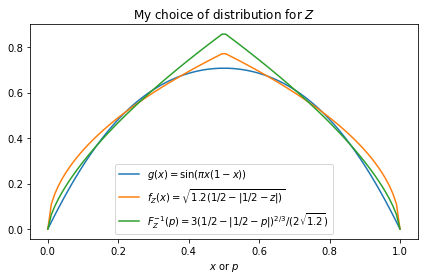

In [138]:
# Test for the function I found.

x = np.linspace(0, 1, 100)
g = lambda x: np.sin(np.pi*x*(1 - x))
f_Z = lambda z: np.sqrt(1.2*(1/2-np.abs(1/2 - z)))
F_Z_inv = lambda p: 3/(2*np.sqrt(1.2))*(1/2 - np.abs(p-.5))**(2/3)

plt.figure()
plt.title("My choice of distribution for $Z$")
plt.plot(x, g(x), label="$g(x) = \sin(\pi x(1-x))$")
plt.plot(x, f_Z(x), label="$f_Z(x) = \sqrt{1.2(1/2-|1/2 - z|)}$")
plt.plot(x, F_Z_inv(x), label="$F_Z^{-1}(p) = 3(1/2 - |1/2 - p|)^{2/3}/(2\sqrt{1.2})$")
plt.xlabel('$x$ or $p$')
plt.legend()
plt.tight_layout()
plt.show()

In [134]:
def sample_nice_Z():
    '''Sample from the nice distribution Z'''
    p = rng.random()
    #return 3/(2*np.sqrt(1.2))*p**(2/3)
    #return 3/(2*np.sqrt(1.2))*(p%.5)**(2/3)
    return 3/(2*np.sqrt(1.2))*np.abs(p - .5)**(2/3)
    #return np.arctan(np.pi*p)/np.pi
    #return 1/3*np.arccos(1-4*p)
    
def sample_X_prime():
    '''Sample from X'.'''
    z = sample_nice_Z()
    return np.sin(np.pi*z*(1 - z))/np.sqrt(1.2*(1/2-np.abs(1/2 - z)))/2
    #return np.sin(np.pi*z*(1 - z))*np.cos(np.pi*z)**2
    #return np.sin(np.pi*z*(1 - z))/(3/2*np.sin(3/2*z)*np.cos(3/2*z))
    
n = 1500
sample_mean, sample_stdev = estimate_expectation(sample_X_prime, n)
print("""
After trial and error, I found that {} trials were sufficient to arrive at an 1-sigma error of around 0.001,
with mean {:.6f} and standard deviation sigma {:.6f}. Wolfram Alpha tells me it should be approximately I =
{}, so I am happy.
      """.format(n, sample_mean, sample_stdev, 0.487595))


After trial and error, I found that 1500 trials were sufficient to arrive at an 1-sigma error of around 0.001,
with mean 0.484070 and standard deviation sigma 0.001016. Wolfram Alpha tells me it should be approximately I =
0.487595, so I am happy.
      


## Direct sampling of Dyck paths

**(35 points)**

Direct sampling of random variables in high dimensions requires some luck and/or ingenuity. Here is an example of a probability distribution on $\mathbb{Z}^{2n+1}$ that features prominently in the combinatorial literature and  can be sampled directly in an efficient manner. A sequence $\mathbf{x}\equiv(x_0,x_1,\ldots,x_{2n})\in\mathbb{Z}^{2n+1}$ is said to be a **Dyck path** if $x_0=x_{2n}=0$, $x_i \geq 0$ and $|x_{i}-x_{i-1}|=1$ for all $i=1,\ldots,2n$. Dyck paths are counted by the Catalan numbers $C(n) = \frac{1}{n+1}\binom{2n}{n}$. Let $\mathbf{X}=(X_0,\ldots,X_n)$ be a **uniform Dyck path**, i.e. a random variable with probability mass function $p_{\mathbf{X}}(\mathbf{x}) = 1/C(n)$ for every Dyck path $\mathbf{x}$. Here is one way to sample $\mathbf{X}$.

In [ ]:
def random_dyck_path(n):
    '''Returns a uniform Dyck path of length 2n as an array [x_0, x_1, ..., x_{2n}] of length 2n.'''
    # produce a (2n+1)-step random walk from 0 to -1
    increments = [1]*n +[-1]*(n+1)
    rng.shuffle(increments)
    unconstrained_walk = np.cumsum(increments)
    # determine the first time it reaches its minimum
    argmin = np.argmin(unconstrained_walk)
    # cyclically permute the increments to ensure walk stays non-negative until last step
    rotated_increments = np.roll(increments,-argmin)
    # turn off the superfluous -1 step
    rotated_increments[0] = 0
    # produce dyck path from increments
    walk = np.cumsum(rotated_increments)
    return walk


plt.plot(random_dyck_path(50))
plt.show()

__(a)__ Let $H$ be the (maximal) height of $X$, i.e. $H=\max_i X_i$. Estimate the expected height $\mathbb{E}[H]$ for $n = 2^5, 2^6, \ldots, 2^{11}$ (including error bars). Determine the growth $\mathbb{E}[H] \approx a\,n^\beta$ via an appropriate fit. *Hint*: use the `scipy.optimize.curve_fit` function with the option `sigma = ...` to incorporate the standard errors on $\mathbb{E}[H]$ in the fit. Note that when you supply the errors appropriately, fitting on linear or logarithmic scale should result in the same answer. **(25 pts)**

In [ ]:
# Collect height estimates
n_values = [2**k for k in range(5,11+1)]
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
from scipy.optimize import curve_fit

# Fitting
# YOUR CODE HERE
raise NotImplementedError()
print("Fit parameters: a = {}, beta = {}".format(a_fit,beta_fit))

In [ ]:
# Plotting
# YOUR CODE HERE
raise NotImplementedError()

__(b)__ Produce a histogram of the height $H / \sqrt{n}$ for $n = 2^5, 2^6, \ldots, 2^{11}$ and $3000$ samples each and demonstrate with a plot that it appears to converge in distribution as $n\to\infty$. *Hint*: you could call `plt.hist(...,density=True,histtype='step')` for each $n$ to plot the densities on top of each other. **(10 pts)**

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()